In [1]:
import re

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
tf.__version__

'2.3.0'

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  print("Invalid device or cannot modify virtual devices once initialized.")
  pass

In [4]:
def preprocess(string):
    string = string.lower()
    return re.sub(r"[\W_]+", " ", string)

In [5]:
train_df = pd.read_json('data/train.jsonl', lines = True)
train_df["text"] = train_df["text"].apply(preprocess)
train_df["img"] = "data/" + train_df["img"]
train_df

,id,img,label,text
0,42953,data/img/42953.png,0,its their character not their color that matters
1,23058,data/img/23058.png,0,don t be afraid to love again everyone is not ...
2,13894,data/img/13894.png,0,putting bows on your pet
3,37408,data/img/37408.png,0,i love everything and everybody except for squ...
4,82403,data/img/82403.png,0,everybody loves chocolate chip cookies even hi...
...,...,...,...,...
8495,10423,data/img/10423.png,1,nobody wants to hang auschwitz me
8496,98203,data/img/98203.png,1,when god grants you a child after 20 years of ...
8497,36947,data/img/36947.png,1,gays on social media equality body positivity ...
8498,16492,data/img/16492.png,1,having a bad day you could be a siamese twin a...


In [6]:
val_df = pd.read_json('data/dev.jsonl', lines = True)

In [7]:
val_df["img"] = "data/" + val_df["img"]
val_df["text"] = val_df["text"].apply(preprocess)

In [8]:
val_df

,id,img,label,text
0,8291,data/img/08291.png,1,white people is this a shooting range
1,46971,data/img/46971.png,1,bravery at its finest
2,3745,data/img/03745.png,1,your order comes to 37 50 and your white privi...
3,83745,data/img/83745.png,1,it is time to send these parasites back to the...
4,80243,data/img/80243.png,1,mississippi wind chime
...,...,...,...,...
495,83675,data/img/83675.png,0,i m gonna be like phelps one day
496,37198,data/img/37198.png,0,when you re so relaxed you can feel yourself g...
497,48670,data/img/48670.png,0,look at this sandwich maker club i found on wi...
498,9863,data/img/09863.png,0,diverse group of women


In [9]:
chars = set(char for label in train_df["text"] for char in label)

In [10]:
img_width = 64
img_height = 64

In [11]:
max_len = max([len(label) for label in train_df["text"]])
max_len

432

In [12]:
count = 1
char_map = {}
for i in chars:
    if i not in char_map.keys():
        char_map[i] = count
        count += 1
    else:
        continue
char_map_reverse = {v:k for k,v in char_map.items()}

In [13]:
def build_model():
    # Inputs to the model
    input_img = tf.keras.layers.Input(
        shape = (img_width, img_height, 3), name = "image"
    )
    
    text = tf.keras.layers.Input(name = "text", shape = (None,))

    x = tf.keras.layers.SeparableConv2D(
        32,
        (3, 3),
        activation = "relu",
        kernel_initializer = "he_normal",
        padding = "same"
    )(input_img)
    
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.GlobalMaxPooling2D()(x)

    y = tf.keras.layers.Embedding(41, 32)(text)
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences = True))(y)
    y = tf.keras.layers.GlobalMaxPool1D()(y)
    
    x = tf.keras.layers.concatenate([x,y])
    
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(128)(x)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    
    out = tf.keras.layers.Dense(1, activation = 'sigmoid', name = "label")(x)

    model = tf.keras.models.Model([input_img, text], out)

    model.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])
    return model

In [14]:
model = build_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 128, 128, 32) 155         image[0][0]                      
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 32)     1312        text[0][0]                       
_______________________________________________________________________________________

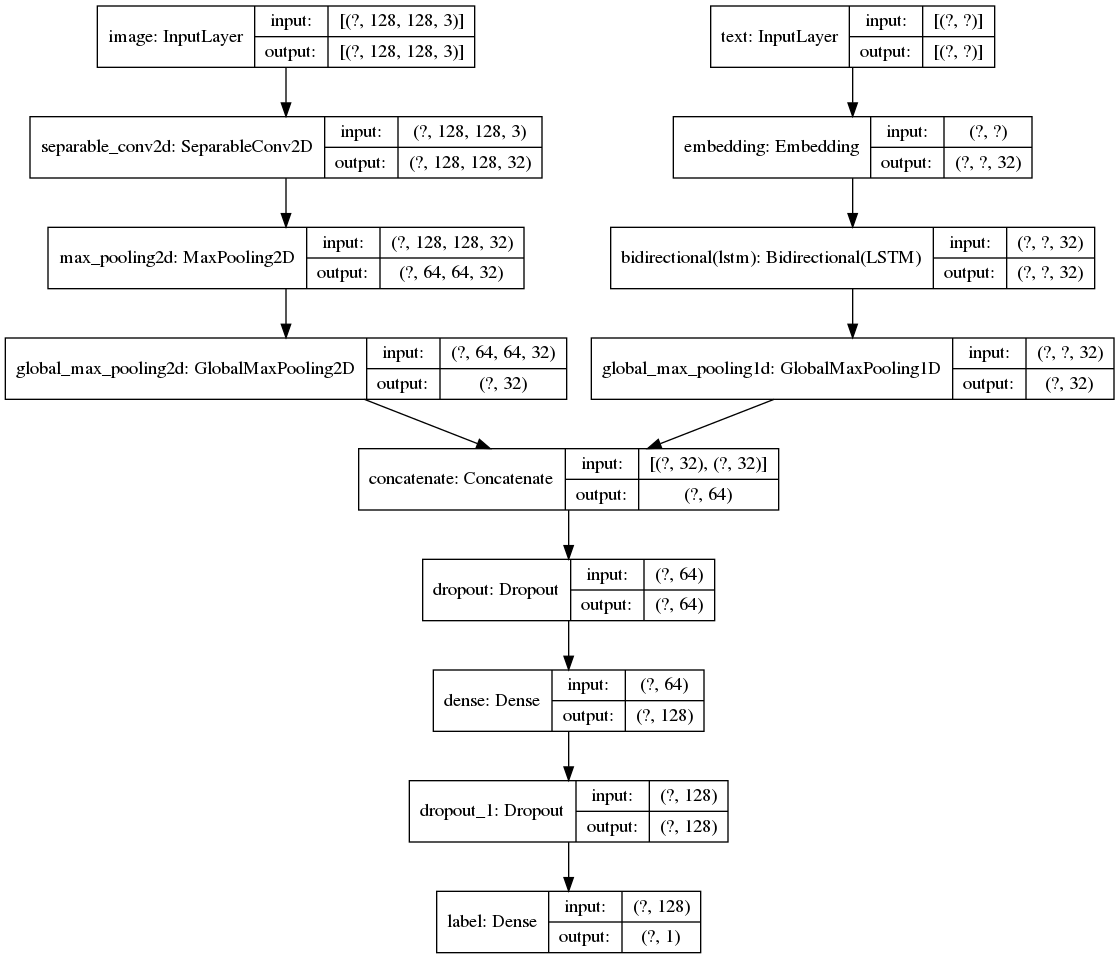

In [15]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [16]:
def encode_single_sample(img_path, label, text):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    text = [char_map[i] for i in text]
    for i in range(max_len - len(text)):
        text.append(0)
    return {"image": img, "label": label, "text": text}

In [17]:
class HatefulMemes(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, input_img_paths, label, text):
        self.batch_size = batch_size
        self.input_img_paths = input_img_paths
        self.text = text
        self.label = label

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_label = self.label[i : i + self.batch_size]
        batch_text = self.text[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + (img_height, img_width) + (3,), dtype = "float32")
        y = np.zeros((self.batch_size,) + (max_len,), dtype = "uint8")
        z = np.zeros((self.batch_size,), dtype = "uint8")
        
        for i,j,k,l in zip(range(self.batch_size), batch_input_img_paths, batch_label, batch_text):
            sample = encode_single_sample(j,k,l)
            x[i] = sample["image"].numpy().tolist()
            y[i] = sample["text"]
            z[i] = sample["label"]
        
        return [x,y], z

In [18]:
train_gen = HatefulMemes(16, train_df["img"].values.tolist(), train_df["label"].values.tolist(), train_df["text"].values.tolist())
val_gen = HatefulMemes(16, val_df["img"].values.tolist(), val_df["label"].values.tolist(), val_df["text"].values.tolist())

In [ ]:
epochs = 100
early_stopping_patience = 3

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy", patience = early_stopping_patience, restore_best_weights = True
)

# Train the model
history = model.fit(
    train_gen,
    validation_data = val_gen, 
    epochs = epochs,
    callbacks = [early_stopping],
)

Epoch 1/100
531/531 [==============================] - -86118s -162180752us/step - loss: 0.6489 - accuracy: 0.6407 - val_loss: 0.7421 - val_accuracy: 0.5020
Epoch 2/100
 95/531 [====>.........................] - ETA: 3:45 - loss: 0.6441 - accuracy: 0.6414